In [2]:


# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


How to use R and Python together in Colab

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


测试R是否可用

In [6]:
%%R
x <- seq(0, 2*pi, length.out=50)
x

 [1] 0.0000000 0.1282283 0.2564565 0.3846848 0.5129131 0.6411414 0.7693696
 [8] 0.8975979 1.0258262 1.1540544 1.2822827 1.4105110 1.5387393 1.6669675
[15] 1.7951958 1.9234241 2.0516523 2.1798806 2.3081089 2.4363372 2.5645654
[22] 2.6927937 2.8210220 2.9492502 3.0774785 3.2057068 3.3339351 3.4621633
[29] 3.5903916 3.7186199 3.8468481 3.9750764 4.1033047 4.2315330 4.3597612
[36] 4.4879895 4.6162178 4.7444460 4.8726743 5.0009026 5.1291309 5.2573591
[43] 5.3855874 5.5138157 5.6420439 5.7702722 5.8985005 6.0267288 6.1549570
[50] 6.2831853


In [7]:
!wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

--2021-07-06 02:09:38--  https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv [following]
--2021-07-06 02:09:39--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.1s    

2021-07-06 02:09:39 (22.3 MB/s) - ‘compas-scores-t

In [8]:
%%R
library(dplyr)
library(ggplot2)
raw_data <- read.csv("./compas-scores-two-years.csv")
nrow(raw_data)

[1] 7214




However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

    If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.



In [9]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172


Higher COMPAS scores are slightly correlated with a longer length of stay.

In [10]:
%%R
df$length_of_stay <- as.numeric(as.Date(df$c_jail_out) - as.Date(df$c_jail_in))
cor(df$length_of_stay, df$decile_score)

[1] 0.2073297


After filtering we have the following demographic breakdown:

In [11]:
%%R
summary(df$age_cat)

   Length     Class      Mode 
     6172 character character 


In [12]:
%%R
summary(df$race)

   Length     Class      Mode 
     6172 character character 


In [13]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [14]:
%%R
summary(df$score_text)

   Length     Class      Mode 
     6172 character character 


In [15]:
%%R
xtabs(~ sex + race, data=df)

        race
sex      African-American Asian Caucasian Hispanic Native American Other
  Female              549     2       482       82               2    58
  Male               2626    29      1621      427               9   285


In [16]:
%%R
summary(df$sex)


   Length     Class      Mode 
     6172 character character 


In [17]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [18]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 2809


In [19]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 45.51199


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

In [21]:
%%R
install.packages("gridExtra")
library(gridExtra);

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gridExtra_2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1062844 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

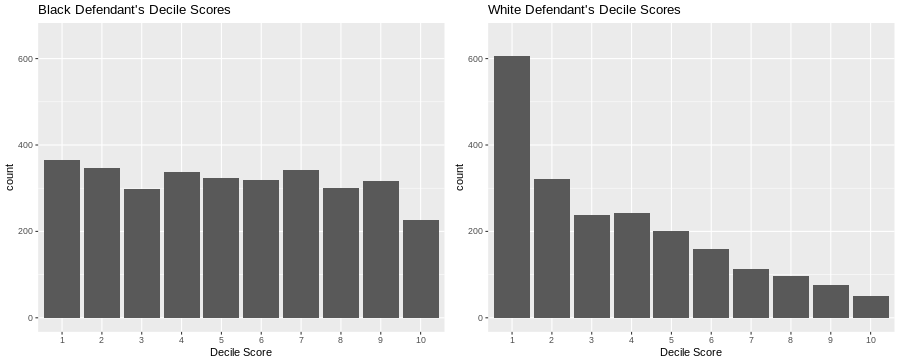

In [22]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("Black Defendant's Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("White Defendant's Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

In [23]:
%%R
xtabs(~ decile_score + race, data=df)

            race
decile_score African-American Asian Caucasian Hispanic Native American Other
          1               365    15       605      159               0   142
          2               346     4       321       89               2    60
          3               298     5       238       73               1    32
          4               337     0       243       47               0    39
          5               323     1       200       39               0    19
          6               318     2       160       27               2    20
          7               343     1       113       28               2     9
          8               301     2        96       14               0     7
          9               317     0        77       17               2     7
          10              227     1        50       16               2     8



Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.


In [24]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9966  -0.7919  -0.3303   0.8121   2.6024  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.52554    0.07851 -19.430  < 2e-16 ***
gender_factorFemale          0.22127    0.07951   2.783 0.005388 ** 
age_factorGreater than 45   -1.35563    0.09908 -13.682  < 2e-16 ***
age_factorLess than 25       1.30839    0.07593  17.232  < 2e-16 ***
race_factorAfrican-American  0.47721    0.06935   6.881 5.93e-12 ***
race_factorAsian            -0.25441    0.47821  -0.532 0.594717    
race_factorHispanic         -0.42839    0.12813  -3.344 0.000827 ***
race_factorNative American   1.39421    0.76612   1.820 0.068784 .  
race_factorOther            -0.82635    0.16208  -5.098 3.43e-07 ***
priors_count  

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [25]:
%%R
control <- exp(-1.52554) / (1 + exp(-1.52554))
exp(0.47721) / (1 - control + (control * exp(0.47721)))


[1] 1.452841


Women are 19.4% more likely than men to get a higher score.

In [26]:
%%R
exp(0.22127) / (1 - control + (control * exp(0.22127)))

[1] 1.194798


Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [27]:
%%R
exp(1.30839) / (1 - control + (control * exp(1.30839)))

[1] 2.49612



Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.


In [28]:
!wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years-violent.csv

--2021-07-06 02:20:17--  https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years-violent.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv [following]
--2021-07-06 02:20:18--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1603205 (1.5M) [text/plain]
Saving to: ‘compas-scores-two-years-violent.csv’

compas-scores-two-y 100%[===================>]   1.53M  --.-KB/s    in 0.08s   

2021-07-06 02:20:1

In [33]:
%%R
raw_data <- read.csv("./compas-scores-two-years-violent.csv")
nrow(raw_data)

[1] 4743


In [34]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
                    days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>% 
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(v_score_text != 'N/A')
nrow(df)

[1] 4020


In [35]:
%%R
summary(df$age_cat)

   Length     Class      Mode 
     4020 character character 


In [32]:
%%R
summary(df$race)

   Length     Class      Mode 
     4020 character character 


In [36]:


%%R
summary(df$v_score_text)



   Length     Class      Mode 
     4020 character character 


In [37]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 16.21891


In [38]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 652


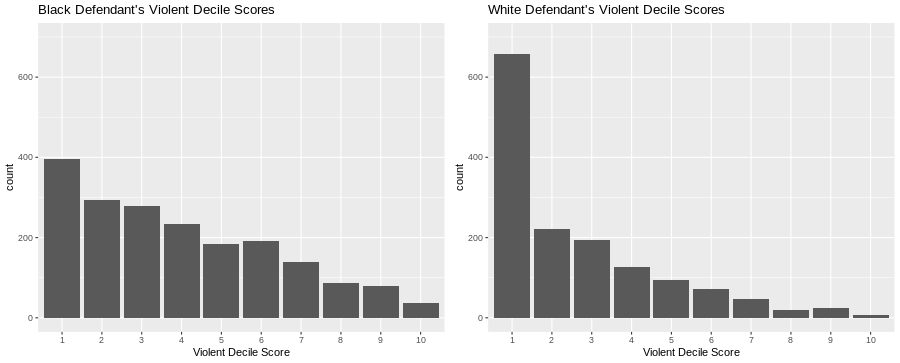

In [39]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("Black Defendant's Violent Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("White Defendant's Violent Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

In [40]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(v_score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9304  -0.5667  -0.3161   0.4192   2.8386  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -2.24274    0.11326 -19.802  < 2e-16 ***
gender_factorFemale         -0.72890    0.12666  -5.755 8.66e-09 ***
age_factorGreater than 45   -1.74208    0.18415  -9.460  < 2e-16 ***
age_factorLess than 25       3.14591    0.11541  27.259  < 2e-16 ***
race_factorAfrican-American  0.65893    0.10815   6.093 1.11e-09 ***
race_factorAsian            -0.98521    0.70537  -1.397   0.1625    
race_factorHispanic         -0.06416    0.19133  -0.335   0.7374    
race_factorNative American   0.44793    1.03546   0.433   0.6653    
race_factorOther            -0.20543    0.22464  -0.914   0.3605    
priors_count  



The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.


In [41]:
%%R
control <- exp(-2.24274) / (1 + exp(-2.24274))
exp(0.65893) / (1 - control + (control * exp(0.65893)))

[1] 1.773921




Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.


In [46]:
%%R
exp(3.14591) / (1 - control + (control * exp(3.14591)))

[1] 7.41424



Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk, we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their validation study.

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.


In [43]:
!wget https://github.com/propublica/compas-analysis/raw/master/cox-parsed.csv

--2021-07-06 02:24:25--  https://github.com/propublica/compas-analysis/raw/master/cox-parsed.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv [following]
--2021-07-06 02:24:26--  https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4594051 (4.4M) [text/plain]
Saving to: ‘cox-parsed.csv’

cox-parsed.csv      100%[===================>]   4.38M  27.5MB/s    in 0.2s    

2021-07-06 02:24:26 (27.5 MB/s) - ‘cox-parsed.csv’ saved [4594051/4594051]



In [49]:
%%R
install.packages("ggfortify")
library(ggfortify);

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggfortify_0.4.11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1952401 bytes (1.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

In [50]:
%%R
library(survival)
library(ggfortify)

data <- filter(filter(read.csv("./cox-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))

grp <- data[!duplicated(data$id),]
nrow(grp)

[1] 10314


In [51]:
%%R
summary(grp$score_factor)

   Low   High Medium 
  5751   1952   2611 


In [52]:
%%R
summary(grp$race_factor)

       Caucasian African-American            Asian         Hispanic 
            3569             5147               51              944 
 Native American            Other 
              32              571 


In [53]:


%%R
f <- Surv(start, end, event, type="counting") ~ score_factor
model <- coxph(f, data=data)
summary(model)



Call:
coxph(formula = f, data = data)

  n= 13344, number of events= 3469 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.24969   3.48927  0.04146 30.14   <2e-16 ***
score_factorMedium 0.79627   2.21725  0.04077 19.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.489     0.2866     3.217     3.785
score_factorMedium     2.217     0.4510     2.047     2.402

Concordance= 0.636  (se = 0.005 )
Likelihood ratio test= 942.8  on 2 df,   p=<2e-16
Wald test            = 954.8  on 2 df,   p=<2e-16
Score (logrank) test = 1055  on 2 df,   p=<2e-16



People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [54]:
%%R
decile_f <- Surv(start, end, event, type="counting") ~ decile_score
dmodel <- coxph(decile_f, data=data)
summary(dmodel)

Call:
coxph(formula = decile_f, data = data)

  n= 13344, number of events= 3469 

                 coef exp(coef) se(coef)     z Pr(>|z|)    
decile_score 0.194931  1.215228 0.005801 33.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
decile_score     1.215     0.8229     1.201     1.229

Concordance= 0.664  (se = 0.005 )
Likelihood ratio test= 1112  on 1 df,   p=<2e-16
Wald test            = 1129  on 1 df,   p=<2e-16
Score (logrank) test = 1208  on 1 df,   p=<2e-16





COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.


In [55]:
%%R
f2 <- Surv(start, end, event, type="counting") ~ race_factor + score_factor + race_factor * score_factor
model <- coxph(f2, data=data)
print(summary(model))

Call:
coxph(formula = f2, data = data)

  n= 13344, number of events= 3469 

                                                   coef exp(coef) se(coef)
race_factorAfrican-American                     0.27879   1.32154  0.06080
race_factorAsian                               -0.77694   0.45981  0.50200
race_factorHispanic                            -0.06352   0.93846  0.09673
race_factorNative American                     -1.25468   0.28517  1.00100
race_factorOther                                0.01419   1.01429  0.11049
score_factorHigh                                1.28350   3.60927  0.08357
score_factorMedium                              0.84286   2.32301  0.07142
race_factorAfrican-American:score_factorHigh   -0.18976   0.82716  0.09985
race_factorAsian:score_factorHigh               1.31556   3.72684  0.76835
race_factorHispanic:score_factorHigh           -0.11913   0.88769  0.19833
race_factorNative American:score_factorHigh     1.95571   7.06896  1.08336
race_factorOther:score_



The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.


In [56]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
print("White High Hazard: %.2f" % (math.exp(1.28350)))
print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

Black High Hazard: 2.99
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.32


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



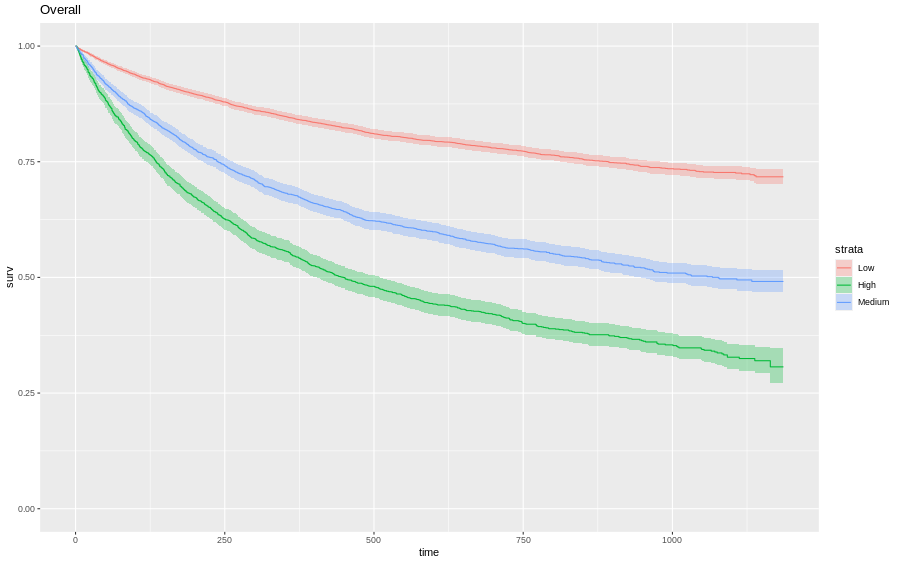

In [57]:
%%R -w 900 -h 563 -u px

fit <- survfit(f, data=data)

plotty <- function(fit, title) {
  return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
}
plotty(fit, "Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



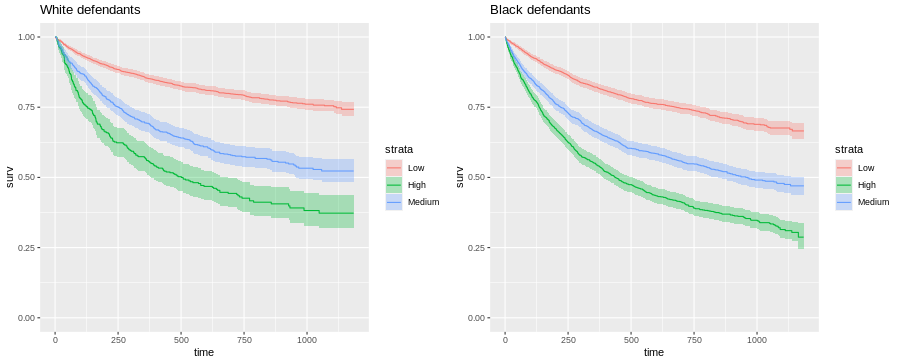

In [58]:
%%R -w 900 -h 363 -u px
white <- filter(data, race == "Caucasian")
white_fit <- survfit(f, data=white)

black <- filter(data, race == "African-American")
black_fit <- survfit(f, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)


In [59]:
%%R
summary(fit, times=c(730))

Call: survfit(formula = f, data = data)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     2.75e+03     1.21e+03     7.76e-01     5.74e-03     7.64e-01 
upper 95% CI 
    7.87e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     505.0000     972.0000       0.4081       0.0122       0.3850 
upper 95% CI 
      0.4327 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     9.79e+02     1.02e+03     5.63e-01     1.03e-02     5.43e-01 
upper 95% CI 
    5.84e-01 



In [60]:
%%R
summary(black_fit, times=c(730))

Call: survfit(formula = f, data = black)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     1.02e+03     5.29e+02     7.43e-01     9.70e-03     7.24e-01 
upper 95% CI 
    7.62e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     362.0000     719.0000       0.3976       0.0142       0.3707 
upper 95% CI 
      0.4265 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     578.0000     623.0000       0.5485       0.0134       0.5227 
upper 95% CI 
      0.5755 



In [61]:
%%R
summary(white_fit, times=c(730))

Call: survfit(formula = f, data = white)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     1.16e+03     4.57e+02     7.95e-01     8.63e-03     7.78e-01 
upper 95% CI 
    8.12e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     102.0000     191.0000       0.4347       0.0272       0.3846 
upper 95% CI 
      0.4914 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     299.0000     306.0000       0.5757       0.0185       0.5405 
upper 95% CI 
      0.6132 



Race specific models have similar concordance values.

In [62]:
%%R
summary(coxph(f, data=white))

Call:
coxph(formula = f, data = white)

  n= 4564, number of events= 1023 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.27628   3.58327  0.08365 15.26   <2e-16 ***
score_factorMedium 0.83965   2.31556  0.07144 11.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.583     0.2791     3.041     4.222
score_factorMedium     2.316     0.4319     2.013     2.664

Concordance= 0.625  (se = 0.008 )
Likelihood ratio test= 262.8  on 2 df,   p=<2e-16
Wald test            = 282.2  on 2 df,   p=<2e-16
Score (logrank) test = 311.7  on 2 df,   p=<2e-16



In [63]:
%%R
summary(coxph(f, data=black))

Call:
coxph(formula = f, data = black)

  n= 6862, number of events= 2035 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.09514   2.98959  0.05475 20.00   <2e-16 ***
score_factorMedium 0.67025   1.95473  0.05636 11.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       2.990     0.3345     2.685     3.328
score_factorMedium     1.955     0.5116     1.750     2.183

Concordance= 0.623  (se = 0.006 )
Likelihood ratio test= 416.9  on 2 df,   p=<2e-16
Wald test            = 401.3  on 2 df,   p=<2e-16
Score (logrank) test = 432.9  on 2 df,   p=<2e-16



Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [65]:
!wget https://github.com/propublica/compas-analysis/raw/master/cox-violent-parsed.csv

--2021-07-06 02:33:03--  https://github.com/propublica/compas-analysis/raw/master/cox-violent-parsed.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-violent-parsed.csv [following]
--2021-07-06 02:33:03--  https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-violent-parsed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6395354 (6.1M) [text/plain]
Saving to: ‘cox-violent-parsed.csv’

cox-violent-parsed. 100%[===================>]   6.10M  30.5MB/s    in 0.2s    

2021-07-06 02:33:04 (30.5 MB/s) - ‘cox-violent-parsed.csv’ saved [6395

In [66]:
%%R
violent_data <- filter(filter(read.csv("./cox-violent-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))


vf <- Surv(start, end, event, type="counting") ~ score_factor
vmodel <- coxph(vf, data=violent_data)
vgrp <- violent_data[!duplicated(violent_data$id),]
print(nrow(vgrp))
summary(vmodel)

[1] 10985
Call:
coxph(formula = vf, data = violent_data)

  n= 18178, number of events= 818 

                      coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.38311   3.98729  0.08410 16.447   <2e-16 ***
score_factorMedium 0.80350   2.23334  0.08699  9.236   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.987     0.2508     3.381     4.702
score_factorMedium     2.233     0.4478     1.883     2.649

Concordance= 0.651  (se = 0.009 )
Likelihood ratio test= 270.6  on 2 df,   p=<2e-16
Wald test            = 272.2  on 2 df,   p=<2e-16
Score (logrank) test = 307.9  on 2 df,   p=<2e-16



In this case, there isn't a significant coefficient on African American's with High Scores.

In [67]:
%%R
vf2 <- Surv(start, end, event, type="counting") ~ race_factor + race_factor * score_factor
vmodel <- coxph(vf2, data=violent_data)
summary(vmodel)

Call:
coxph(formula = vf2, data = violent_data)

  n= 18178, number of events= 818 

                                                     coef  exp(coef)   se(coef)
race_factorAfrican-American                     1.976e-01  1.219e+00  1.321e-01
race_factorAsian                               -5.838e-01  5.577e-01  1.005e+00
race_factorHispanic                            -1.754e-01  8.391e-01  2.150e-01
race_factorNative American                     -1.304e+01  2.162e-06  7.607e+02
race_factorOther                               -4.459e-02  9.564e-01  2.433e-01
score_factorHigh                                1.250e+00  3.491e+00  1.720e-01
score_factorMedium                              6.292e-01  1.876e+00  1.583e-01
race_factorAfrican-American:score_factorHigh   -7.627e-03  9.924e-01  2.063e-01
race_factorAsian:score_factorHigh               1.552e+00  4.721e+00  1.425e+00
race_factorHispanic:score_factorHigh            1.606e-01  1.174e+00  3.969e-01
race_factorNative American:score_fa

In [68]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "African-American")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "African-American"))

  n= 9712, number of events= 495 

                     coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.2412    3.4596   0.1140 10.891  < 2e-16 ***
score_factorMedium 0.7589    2.1359   0.1202  6.315 2.71e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.460     0.2891     2.767     4.325
score_factorMedium     2.136     0.4682     1.688     2.703

Concordance= 0.638  (se = 0.012 )
Likelihood ratio test= 127.5  on 2 df,   p=<2e-16
Wald test            = 118.7  on 2 df,   p=<2e-16
Score (logrank) test = 130.9  on 2 df,   p=<2e-16



In [69]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "Caucasian")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "Caucasian"))

  n= 6041, number of events= 221 

                     coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.2502    3.4909   0.1720 7.267 3.67e-13 ***
score_factorMedium 0.6310    1.8794   0.1583 3.986 6.71e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.491     0.2865     2.492     4.891
score_factorMedium     1.879     0.5321     1.378     2.563

Concordance= 0.61  (se = 0.018 )
Likelihood ratio test= 49.63  on 2 df,   p=2e-11
Wald test            = 55.48  on 2 df,   p=9e-13
Score (logrank) test = 61.24  on 2 df,   p=5e-14



R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



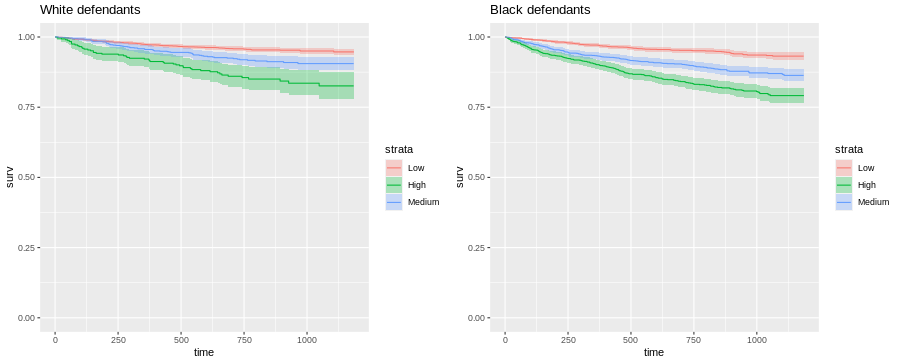

In [70]:
%%R -w 900 -h 363 -u px
white <- filter(violent_data, race == "Caucasian")
white_fit <- survfit(vf, data=white)

black <- filter(violent_data, race == "African-American")
black_fit <- survfit(vf, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)


Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.


In [72]:
class Person:
    def __init__(self, reader):
        self.__rows = []
        self.__idx = reader.peek()['id']
        try:
            while reader.peek()['id'] == self.__idx:
                self.__rows.append(next(reader))
        except StopIteration:
            pass

    @property
    def lifetime(self):
        memo = 0
        for it in self.__rows:
            memo += int(it['end']) - int(it['start'])
        return memo

    @property
    def recidivist(self):
        return (self.__rows[0]['is_recid'] == "1" and
                self.lifetime <= 730)

    @property
    def violent_recidivist(self):
        return (self.__rows[0]['is_violent_recid'] == "1" and
                self.lifetime <= 730)

    @property
    def low(self):
        return self.__rows[0]['score_text'] == "Low"

    @property
    def high(self):
        return not self.low

    @property
    def low_med(self):
        return self.low or self.score == "Medium"

    @property
    def true_high(self):
        return self.score == "High"

    @property
    def vlow(self):
        return self.__rows[0]['v_score_text'] == "Low"

    @property
    def vhigh(self):
        return not self.vlow

    @property
    def vlow_med(self):
        return self.vlow or self.vscore == "Medium"

    @property
    def vtrue_high(self):
        return self.vscore == "High"

    @property
    def score(self):
        return self.__rows[0]['score_text']

    @property
    def vscore(self):
        return self.__rows[0]['v_score_text']

    @property
    def race(self):
        return self.__rows[0]['race']

    @property
    def valid(self):
        return (self.__rows[0]['is_recid'] != "-1" and
                (self.recidivist and self.lifetime <= 730) or
                self.lifetime > 730)

    @property
    def compas_felony(self):
        return 'F' in self.__rows[0]['c_charge_degree']

    @property
    def score_valid(self):
        return self.score in ["Low", "Medium", "High"]

    @property
    def vscore_valid(self):
        return self.vscore in ["Low", "Medium", "High"]

    @property
    def rows(self):
        return self.__rows

In [73]:
class PeekyReader:
    def __init__(self, reader):
        self.peeked = None
        self.reader = reader

    def peek(self):
        if self.peeked is None:
            self.peeked = next(self.reader)
        return self.peeked

    def __iter__(self):
        return self

    def __next__(self):
        if self.peeked is not None:
            ret = self.peeked
            self.peeked = None
            return ret
        try:
            return next(self.reader)
        except StopIteration:
            self.peeked = None
            raise StopIteration


In [74]:
!wget https://github.com/propublica/compas-analysis/raw/master/cox-parsed.csv

--2021-07-06 02:37:23--  https://github.com/propublica/compas-analysis/raw/master/cox-parsed.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv [following]
--2021-07-06 02:37:24--  https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4594051 (4.4M) [text/plain]
Saving to: ‘cox-parsed.csv.1’

cox-parsed.csv.1    100%[===================>]   4.38M  26.3MB/s    in 0.2s    

2021-07-06 02:37:24 (26.3 MB/s) - ‘cox-parsed.csv.1’ saved [4594051/4594051]



In [75]:

from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [79]:
def count(fn, data):
    return len(list(filter(fn, list(data))))

In [82]:
def t(tn, fp, fn, tp):
    surv = tn + fp
    recid = tp + fn
    print("           \tLow\tHigh")
    print("Survived   \t%i\t%i\t%.2f" % (tn, fp, surv / (surv + recid)))
    print("Recidivated\t%i\t%i\t%.2f" % (fn, tp, recid / (surv + recid)))
    print("Total: %.2f" % (surv + recid))
    print("False positive rate: %.2f" % (fp / surv * 100))
    print("False negative rate: %.2f" % (fn / recid * 100))
    spec = tn / (tn + fp)
    sens = tp / (tp + fn)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    prev = recid / (surv + recid)
    print("Specificity: %.2f" % spec)
    print("Sensitivity: %.2f" % sens)
    print("Prevalence: %.2f" % prev)
    print("PPV: %.2f" % ppv)
    print("NPV: %.2f" % npv)
    print("LR+: %.2f" % (sens / (1 - spec)))
    print("LR-: %.2f" % ((1-sens) / spec))

In [83]:
def table(recid, surv, prefix=''):
    tn = count(lambda i: getattr(i, prefix + 'low'), surv)
    fp = count(lambda i: getattr(i, prefix + 'high'), surv)
    fn = count(lambda i: getattr(i, prefix + 'low'), recid)
    tp = count(lambda i: getattr(i, prefix + 'high'), recid)
    t(tn, fp, fn, tp)

In [84]:
print("All defendants")
table(list(recid), list(surv))



All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [85]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [86]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [89]:
def is_race(race):
    return lambda x: x.race == race

In [90]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51




That number is higher for African Americans at 44.85%.


In [91]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


In [92]:
44.85 / 23.45

1.9125799573560769



Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.


In [93]:
47.72 / 27.99

1.7048946052161487

In [95]:
def hightable(recid, surv, prefix=''):
    tn = count(lambda i: getattr(i, prefix + 'low_med'), surv)
    fp = count(lambda i: getattr(i, prefix + 'true_high'), surv)
    fn = count(lambda i: getattr(i, prefix + 'low_med'), recid)
    tp = count(lambda i: getattr(i, prefix + 'true_high'), recid)
    t(tn, fp, fn, tp)

In [96]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [97]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72



Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.


In [98]:
vpeople = []
with open("./cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [100]:
def vtable(recid, surv):
    table(recid, surv, prefix='v')

In [101]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even moreso for Black defendants.

In [102]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [103]:


print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))



White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [104]:
38.14 / 18.46


2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [105]:
62.62 / 38.37


1.63200416992442


Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.


In [106]:
%%R

female <- filter(data, sex == "Female")
male   <- filter(data, sex == "Male")
male_fit <- survfit(f, data=male)
female_fit <- survfit(f, data=female)

In [107]:
%%R
summary(male_fit, times=c(730))

Call: survfit(formula = f, data = male)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     2.13e+03     1.02e+03     7.58e-01     6.67e-03     7.45e-01 
upper 95% CI 
    7.71e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
     730.000      421.000      857.000        0.388        0.013        0.363 
upper 95% CI 
       0.414 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     752.0000     838.0000       0.5352       0.0118       0.5126 
upper 95% CI 
      0.5588 



In [108]:
%%R
summary(female_fit, times=c(730))

Call: survfit(formula = f, data = female)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     617.0000     194.0000       0.8381       0.0107       0.8174 
upper 95% CI 
      0.8593 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000      84.0000     115.0000       0.5252       0.0325       0.4652 
upper 95% CI 
      0.5929 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     227.0000     184.0000       0.6586       0.0206       0.6194 
upper 95% CI 
      0.7003 



R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



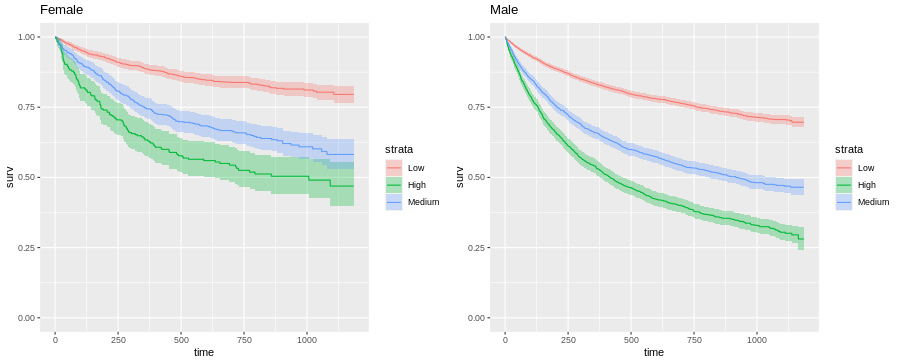

In [109]:
%%R -w 900 -h 363 -u px
grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.

code modified from:https://github.com/propublica/compas-analysis